loss (hidden nodes : 5, iteration: 2000): 5.75
loss (hidden nodes : 10, iteration: 2000): 32.62
loss (hidden nodes : 20, iteration: 2000): 5.61


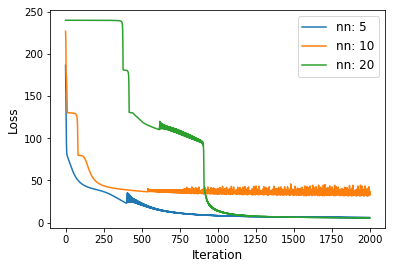

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

IRIS_TRAIN = "http://download.tensorflow.org/data/iris_training.csv"
IRIS_TEST = "http://download.tensorflow.org/data/iris_test.csv"

names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
train = pd.read_csv(IRIS_TRAIN, names=names, skiprows=1)
test = pd.read_csv(IRIS_TEST, names=names, skiprows=1)

Xtrain = train.drop('species', axis=1)
Xtest= test.drop('species', axis=1)

ytrain = pd.get_dummies(train.species)
ytest = pd.get_dummies(test.species)

def create_train_model(hidden_nodes, num_iters):

    tf.reset_default_graph()

    X = tf.placeholder(shape=(120, 4), dtype=tf.float64, name='X')
    y = tf.placeholder(shape=(120, 3), dtype=tf.float64, name='y')

    W1 = tf.Variable(np.random.rand(4, hidden_nodes), dtype=tf.float64)
    W2 = tf.Variable(np.random.rand(hidden_nodes, 3), dtype=tf.float64)

    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))

    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)

    optimizor = tf.train.GradientDescentOptimizer(0.005)
    train = optimizor.minimize(loss)

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    for i in range(num_iters):
        sess.run(train, feed_dict={X: Xtrain, y: ytrain})
        loss_plot[hidden_nodes].append(
                sess.run(loss, feed_dict={X: Xtrain.as_matrix(), y: ytrain.as_matrix()}))
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)

    print "loss (hidden nodes : %d, iteration: %d): %.2f" % (hidden_nodes, num_iters, loss_plot[hidden_nodes][-1])
    tf.summary.FileWriter('ten', sess.graph)
    return weights1, weights2

num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20:[]}
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
num_iters = 2000

for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: %d"%hidden_nodes)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)



In [7]:
X = tf.placeholder(shape=(30, 4), dtype=tf.float64, name='X')
y = tf.placeholder(shape=(30, 3), dtype=tf.float64, name='y')

for hidden_nodes  in num_hidden_nodes:
    W1 = tf.Variable(weights1[hidden_nodes])
    W2 = tf.Variable(weights2[hidden_nodes])
    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        y_est_np = sess.run(y_est, feed_dict={X: Xtest, y: ytest})
    
    correct = [estimate.argmax(axis=0) == target.argmax(axis=0)
              for estimate, target in zip(y_est_np, ytest.as_matrix())]
    accuracy = 100 * sum(correct)/ len(correct)
    print 'accuracy : %.2f' % accuracy

accuracy : 96.00
accuracy : 93.00
accuracy : 96.00


## t-SNE

In [2]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

In [3]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel

In [4]:
RS = 20150101

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

In [6]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [7]:
digits = load_digits()
digits.data.shape
# print(digits['DESCR'])

(1797, 64)

/root/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


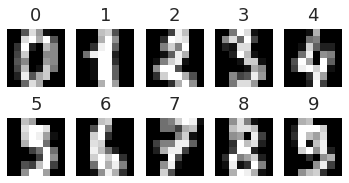

In [8]:
nrows, ncols = 2, 5
plt.figure(figsize=(6, 3))
plt.gray()

for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.matshow(digits.images[i, ...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [9]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [10]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [12]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

#     We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<matplotlib.figure.Figure at 0x7f16634d35d0>,
  <matplotlib.text.Text at 0x7f1660f79350>])

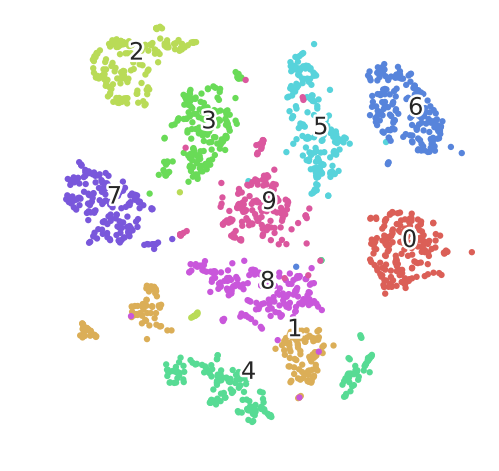

In [13]:
scatter(digits_proj, y)

In [14]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True, n_jobs =-1)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

In [19]:
x = np.array([[0, 2, 3],
       [2, 0, 6],
       [3, 6, 0]])

In [26]:
spatial.distance.cdist(x, np.vstack([x, x])).astype(int)

array([[0, 4, 5, 0, 4, 5],
       [4, 0, 8, 4, 0, 8],
       [5, 8, 0, 5, 8, 0]])

In [18]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D, interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

# plt.subplot(132)
# plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

# plt.subplot(133)
# plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})

MemoryError: 

In [30]:
spatial.distance.is_valid_y([1,2,3,4,1,3])

True